In [74]:
import os
import sys
module_path = os.path.abspath(os.path.join('fede'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import pandas as pd
from client import Client
from supported_modles import Supported_modles
import utils
from fedavg import Fedavg
from sklearn.utils.class_weight import compute_sample_weight
import numpy as np
import random
from copy import deepcopy
import statistics
import matplotlib.pyplot as plt

In [75]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [76]:
selected_model = Supported_modles.SGD_classifier

In [98]:
clients, test_x, test_y = utils.set_data(selected_model, False, True, True)

Creating node1.
Creating node2.
Creating node3.
Creating node4.
Creating node5.


In [99]:
test_y.sum()

49768

In [100]:
f1_before = []
for client in clients:
    client.init_empty_model(0.001, epochs=30)
    try:
        client.train_model(epochs=50)
    except ValueError:
        score = 0
        print(client.name)
        f1_before.append(score)
        continue 
    try: 
        score = client.test_model_f1(y_test=test_y, X_test=test_x)
    except IndexError:
        score = 0
    f1_before.append(score)
    print(score)

0.7547664028001528
0.7574753952035327
0.7573513856568648
0.7571061553441338
0.757123919240741


In [101]:
fedavg = Fedavg("global", selected_model)

[Errno 98] Address already in use
Waitiing for a Connection..


In [102]:
clients.remove(clients[0])

In [103]:
###First learn model on clients:
def plot(epochs, split, rounds):
    epochs = epochs
    split = split
    scores = []

    for _ in range(10):
        round_scores = []
        score = 0
        round_weights = []
        dataset_size = 0
        applicable_models = []
        first = True

        for client in clients:
            client.init_empty_model(0.001,epochs)
            X_train, X_test, y_train, y_test = client.split_data(split)

            # X_train = client.x_chunks[0]
            # y_train = client.y_chunks[0]

            client.train_model(X_train,y_train,epochs=epochs)
            dataset_size += client.x.shape[0]
            round_weights.append(dataset_size)
            applicable_models.append(client.model)
            if first:
                fedavg.init_global_model(client.model)
                first = False
            # print('.')

        round_weights = np.array(round_weights) / dataset_size # calculate weight based on actual dataset size
        fedavg.update_global_model(applicable_models, round_weights, selected_model)

        score = fedavg.test_model_f1(y_test=test_y, X_test=test_x)
        round_scores.append(score)

        number_of_rounds = rounds
        max_score = 0
        optimal_model = None


        for round in range(number_of_rounds):

            applicable_clients = random.sample((clients), len(clients))
            applicable_models = []
            applicable_name = []
            round_weights = []
            dataset_size = 0
            

            for client in applicable_clients:
                # print(f'.', end='')

                X_train, X_test, y_train, y_test = client.split_data(split)

                # X_train = client.x_chunks[round + 1]
                # y_train = client.y_chunks[round + 1]
            
                dataset_size += X_train.shape[0]
                sample_weights = compute_sample_weight('balanced', y=y_train)

                client.load_global_model(fedavg.model)
                client.train_local_agent(X_train, y_train, epochs, sample_weights)
                round_weights.append(X_train.shape[0])
                applicable_models.append(client.model)


            round_weights = np.array(round_weights) / dataset_size
            fedavg.update_global_model(applicable_models, round_weights, selected_model)

            score = fedavg.test_model_f1(y_test=test_y, X_test=test_x)
            round_scores.append(score)
            # print(score, end=' ')
            if score > max_score:
                # print(score)
                max_score = score
                optimal_model = deepcopy(fedavg.model)
        print(score)
        print('--------------------')
        scores.append(round_scores)

    # print(f'epochs: {epochs} split = {split} --- {statistics.mean(scores)} stdev {statistics.stdev(scores)}')
    plt.rcParams["figure.figsize"] = (10,10)
    for x in scores:
        plt.plot(x)

    plt.xlabel("Number of Rounds", fontsize=16)
    plt.ylabel("F1-Score", fontsize=16)
    plt.xticks(range(0,rounds+1,5))
    plt.xticks(size = 16)
    plt.yticks(size = 16)
    plt.title('UNSW - LR-SGD, E=' +str(epochs)+', B=' + str(split) +', C=5')
    plt.show()


In [104]:
###First learn model on clients:
def find_scores(epochs, split, rounds):
    epochs = epochs
    split = split
    scores = []

    for _ in range(10):
        score = 0
        round_weights = []
        dataset_size = 0
        applicable_models = []
        first = True

        for client in clients:
            client.init_empty_model(0.1,epochs)
            X_train, X_test, y_train, y_test = client.split_data(split)

            # X_train = client.x_chunks[0]
            # y_train = client.y_chunks[0]

            client.train_model(X_train,y_train,epochs=epochs)
            dataset_size += client.x.shape[0]
            round_weights.append(dataset_size)
            applicable_models.append(client.model)
            if first:
                fedavg.init_global_model(client.model)
                first = False
            # print('.')

        round_weights = np.array(round_weights) / dataset_size # calculate weight based on actual dataset size
        fedavg.update_global_model(applicable_models, round_weights, selected_model)

        score = fedavg.test_model_f1(y_test=test_y, X_test=test_x)

        number_of_rounds = rounds
        max_score = 0
        optimal_model = None


        for round in range(number_of_rounds):

            applicable_clients = random.sample((clients), len(clients))
            applicable_models = []
            applicable_name = []
            round_weights = []
            dataset_size = 0
            

            for client in applicable_clients:
                # print(f'.', end='')

                X_train, X_test, y_train, y_test = client.split_data(split)

                # X_train = client.x_chunks[round + 1]
                # y_train = client.y_chunks[round + 1]
            
                dataset_size += X_train.shape[0]
                sample_weights = compute_sample_weight('balanced', y=y_train)

                client.load_global_model(fedavg.model)
                client.train_local_agent(X_train, y_train, epochs, sample_weights)
                round_weights.append(X_train.shape[0])
                applicable_models.append(client.model)


            round_weights = np.array(round_weights) / dataset_size
            fedavg.update_global_model(applicable_models, round_weights, selected_model)

            score = fedavg.test_model_f1(y_test=test_y, X_test=test_x)
            # print(score, end=' ')
            if score > max_score:
                # print(score)
                max_score = score
                optimal_model = deepcopy(fedavg.model)
        print(score)
        print('--------------------')
        scores.append(score)

    print(f'epochs: {epochs} split = {split} --- {statistics.mean(scores)} stdev {statistics.stdev(scores)}')
    plt.rcParams["figure.figsize"] = (10,10)
    for x in scores:
        plt.plot(x)

    plt.xlabel("Number of Rounds", fontsize=16)
    plt.ylabel("F1-Score", fontsize=16)
    plt.xticks(range(0,rounds+1,5))
    plt.xticks(size = 16)
    plt.yticks(size = 16)
    plt.title('UNSW - LR-SGD, E=' +str(epochs)+', B=' + str(split) +', C=5')
    plt.show()


In [105]:
# plot(10,0.9,19)

In [106]:
# plot(10,0.8,19)

In [107]:
# plot(20,0.9,9)

In [108]:
# plot(20,0.8,9)

0.7564715581203628
--------------------
0.7564715581203628
--------------------
0.7564715581203628
--------------------
0.7564715581203628
--------------------
0.7564715581203628
--------------------
0.7564715581203628
--------------------
0.7564715581203628
--------------------
0.7564715581203628
--------------------
0.7564715581203628
--------------------
0.7564715581203628
--------------------
epochs: 10 split = 0.9 --- 0.7564715581203628 stdev 0.0


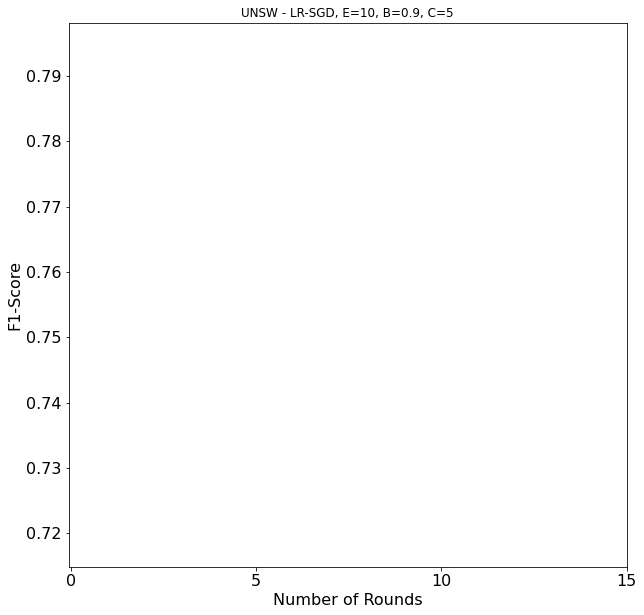

In [110]:
find_scores(10, 0.9, 15)